<a href="https://colab.research.google.com/github/anubhavsingh-123/Adobe-clone/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/maps
!tar -xvf '/content/drive/My Drive/MLDATA/maps.tar.gz' -C /content/

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

In [ ]:
from numpy import zeros, ones
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation,
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt


In [ ]:
def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02)

	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])


	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):

	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	if batchnorm:
		g = BatchNormalization()(g, training=True)

	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

	init = RandomNormal(stddev=0.02)

	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)

	if dropout:
		g = Dropout(0.5)(g, training=True)

	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_shape=(256,256,3)):

	init = RandomNormal(stddev=0.02)

	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1

	model = Model(in_image, out_image)
	return model

In [ ]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		if (i+1) % (bat_per_epo * 1) == 0:
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			summarize_performance(i, g_model, dataset)

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


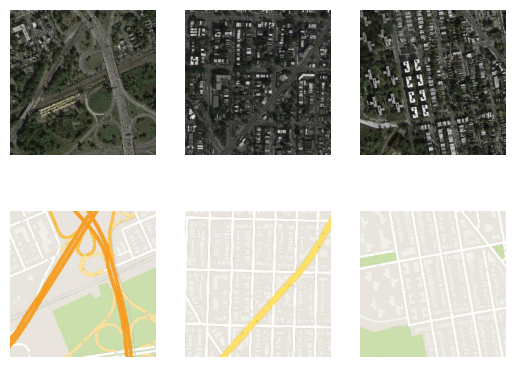

In [ ]:
path = 'maps/train/'
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
data = [src_images, tar_images]
dataset = preprocess_data(data)

In [ ]:
from datetime import datetime
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, n_epochs=30, n_batch=1)
stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

In [ ]:
from keras.models import load_model
from numpy.random import randint
model = load_model('/content/drive/MyDrive/MLDATA/20.h5')

In [ ]:
def plot_images(src_img, gen_img, tar_img):
	from matplotlib import pyplot
	from numpy import vstack

	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']

	# Set figure size (width, height in inches)
	pyplot.figure(figsize=(15, 5))  # You can adjust size as needed

	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i], fontsize=12)

	pyplot.tight_layout()
	pyplot.show()


In [ ]:
def show_image_one(img, title=''):
	from matplotlib import pyplot

	# remove batch dimension if present
	if img.shape[0] == 1:
		img = img.squeeze(0)

	# scale from [-1,1] to [0,1]
	img = (img + 1) / 2.0

	pyplot.figure(figsize=(5, 5))
	pyplot.axis('off')
	pyplot.imshow(img)
	pyplot.title(title, fontsize=12)
	pyplot.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


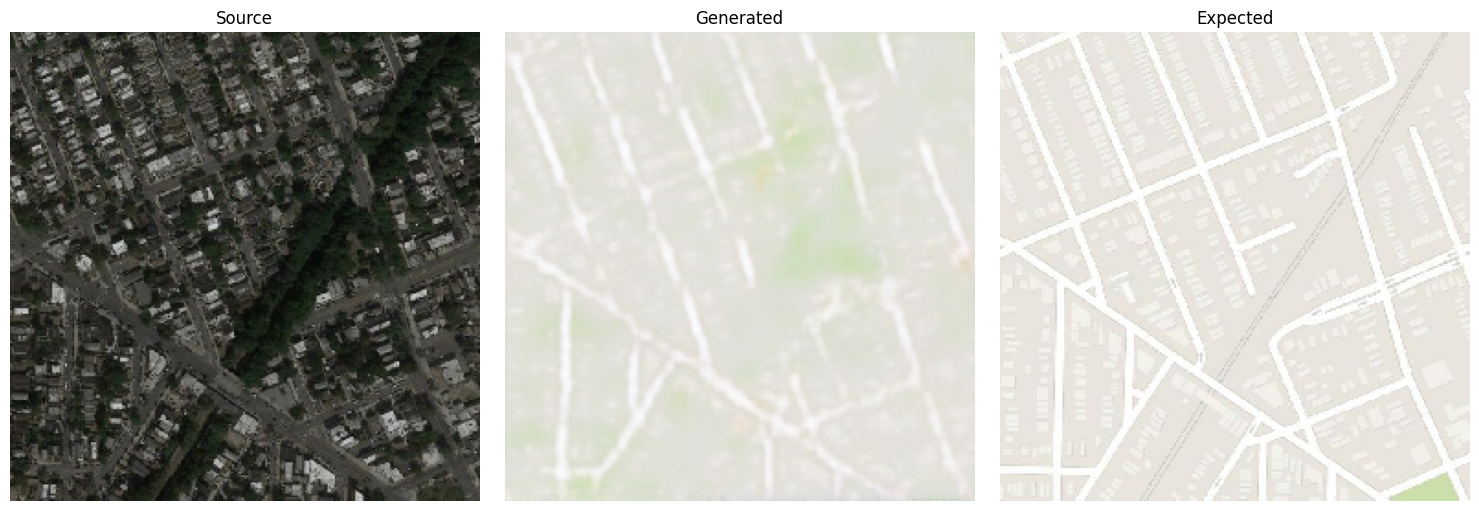

In [ ]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_and_preprocess_image(filepath, size=(256, 512)):
    img = load_img(filepath, target_size=size)
    img = img_to_array(img)
    input_img = img[:, :256]
    target_img = img[:, 256:]

    # Normalize to [-1, 1]
    input_img_norm = (input_img - 127.5) / 127.5
    target_img_norm = (target_img - 127.5) / 127.5

    return input_img_norm, target_img_norm


In [ ]:
from numpy import expand_dims

def predict_image(g_model, input_img):
    input_batch = expand_dims(input_img, axis=0)
    generated = g_model.predict(input_batch)[0]
    return generated


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr_score
from skimage.metrics import structural_similarity as ssim_score
import numpy as np

def compute_metrics(pred, target):
    l1 = np.mean(np.abs(pred - target))

    # Convert to [0, 255]
    pred_img = ((pred + 1) * 127.5).astype('uint8')
    target_img = ((target + 1) * 127.5).astype('uint8')

    psnr = psnr_score(target_img, pred_img, data_range=255)
    ssim = ssim_score(target_img, pred_img, multichannel=True, data_range=255, channel_axis=-1)

    return l1, psnr, ssim

In [ ]:
import matplotlib.pyplot as plt

def plot_generated_image(generated_img, step=None):
    # Rescale from [-1, 1] to [0, 1] for visualization
    gen_img = (generated_img + 1) / 2.0

    plt.figure(figsize=(5, 5))
    plt.axis('off')
    title = f"Generated Image" + (f" at Epoch {step}" if step is not None else "")
    plt.title(title)
    plt.imshow(gen_img)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_source_generated_target(source_img, generated_img, target_img, step=None):
    # Rescale from [-1, 1] to [0, 1] for visualization (if needed)
    def rescale(img):
        return (img + 1) / 2.0 if img.min() < 0 else img

    source_img = rescale(source_img)
    generated_img = rescale(generated_img)
    target_img = rescale(target_img)

    titles = ["Source Image", "Generated Image", "Target Image"]

    plt.figure(figsize=(15, 5))

    for i, img in enumerate([source_img, generated_img, target_img]):
        plt.subplot(1, 3, i + 1)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
L1: 0.0610, PSNR: 27.43 dB, SSIM: 0.6451


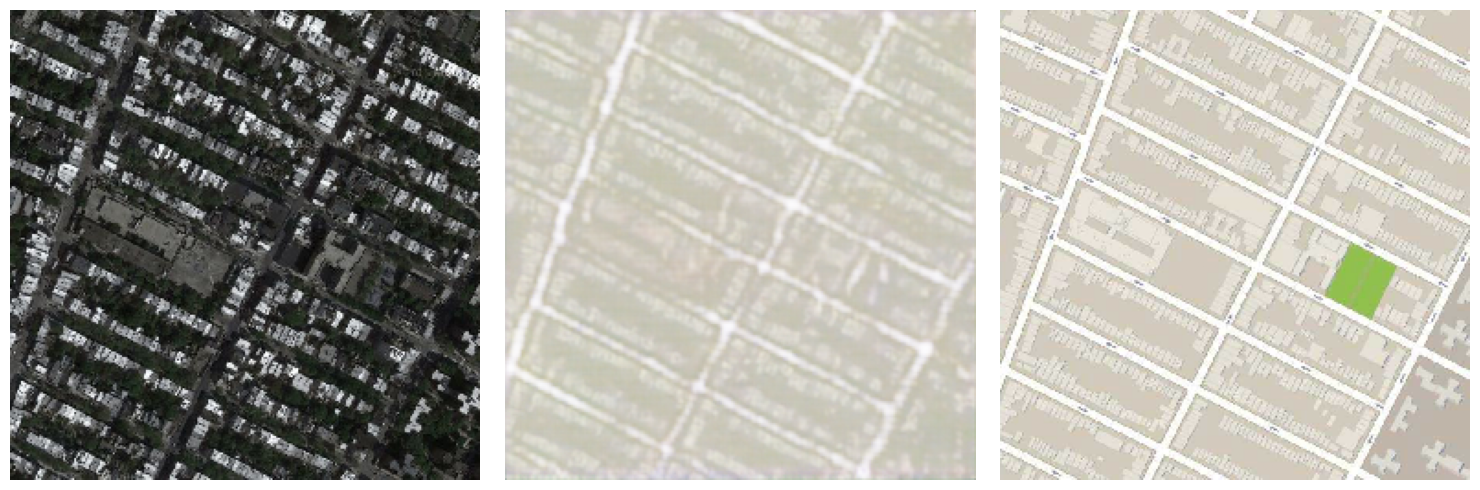

In [ ]:
img_path = 'maps/val/280.jpg'
input_img, target_img = load_and_preprocess_image(img_path)
generated_img = predict_image(model, input_img)
l1, psnr, ssim = compute_metrics(generated_img, target_img)
print(f"L1: {l1:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
plot_source_generated_target(input_img, generated_img, target_img, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
L1: 0.0610, PSNR: 27.43 dB, SSIM: 0.6451


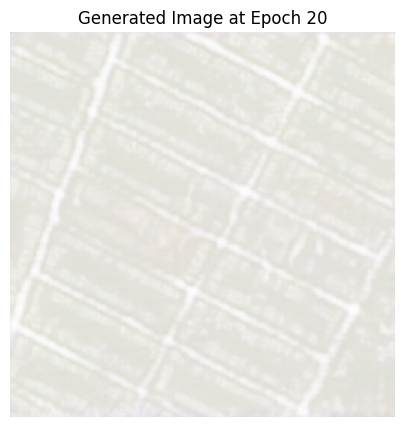

In [ ]:
img_path = 'maps/val/280.jpg'
input_img, target_img = load_and_preprocess_image(img_path)
generated_img = predict_image(model, input_img)
l1, psnr, ssim = compute_metrics(generated_img, target_img)
print(f"L1: {l1:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
plot_generated_image(generated_img, 20)

In [ ]:
import os
from tqdm import tqdm
from numpy import mean

def evaluate_on_dataset(model, path='maps/val/', max_images=100):
    l1_list, psnr_list, ssim_list = [], [], []

    file_list = sorted(os.listdir(path))[:max_images]

    for idx, file in tqdm(enumerate(file_list), total=len(file_list), desc="Evaluating"):
        img_path = os.path.join(path, file)

        try:
            input_img, target_img = load_and_preprocess_image(img_path)
            generated_img = predict_image(model, input_img)
            l1, psnr, ssim = compute_metrics(generated_img, target_img)

            l1_list.append(l1)
            psnr_list.append(psnr)
            ssim_list.append(ssim)

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    # Average Metrics
    avg_l1 = mean(l1_list)
    avg_psnr = mean(psnr_list)
    avg_ssim = mean(ssim_list)

    print(f"\n✅ Evaluation Complete on {len(l1_list)} images")
    print(f"Avg L1 Loss: {avg_l1:.4f}")
    print(f"Avg PSNR   : {avg_psnr:.2f} dB")
    print(f"Avg SSIM   : {avg_ssim:.4f}")

    return l1_list, psnr_list, ssim_list



In [ ]:
l1s, psnrs, ssims = evaluate_on_dataset(model, path='maps/val/', max_images=250)

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:   0%|          | 1/250 [00:00<00:34,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   1%|          | 2/250 [00:00<00:33,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:   1%|          | 3/250 [00:00<00:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:   2%|▏         | 4/250 [00:00<00:30,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:   2%|▏         | 5/250 [00:00<00:29,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:   2%|▏         | 6/250 [00:00<00:28,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:   3%|▎         | 7/250 [00:00<00:27,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:   3%|▎         | 8/250 [00:00<00:27,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   4%|▎         | 9/250 [00:01<00:26,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   4%|▍         | 10/250 [00:01<00:27,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   4%|▍         | 11/250 [00:01<00:28,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   5%|▍         | 12/250 [00:01<00:29,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:   5%|▌         | 13/250 [00:01<00:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:   6%|▌         | 14/250 [00:01<00:32,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:   6%|▌         | 15/250 [00:01<00:32,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:   6%|▋         | 16/250 [00:02<00:34,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:   7%|▋         | 17/250 [00:02<00:34,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:   7%|▋         | 18/250 [00:02<00:35,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:   8%|▊         | 19/250 [00:02<00:35,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   8%|▊         | 20/250 [00:02<00:35,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   8%|▊         | 21/250 [00:02<00:35,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:   9%|▉         | 22/250 [00:02<00:35,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:   9%|▉         | 23/250 [00:03<00:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  10%|▉         | 24/250 [00:03<00:36,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  10%|█         | 25/250 [00:03<00:34,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  10%|█         | 26/250 [00:03<00:34,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  11%|█         | 27/250 [00:03<00:34,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  11%|█         | 28/250 [00:03<00:34,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  12%|█▏        | 29/250 [00:04<00:35,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  12%|█▏        | 30/250 [00:04<00:36,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  12%|█▏        | 31/250 [00:04<00:35,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  13%|█▎        | 32/250 [00:04<00:35,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  13%|█▎        | 33/250 [00:04<00:36,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  14%|█▎        | 34/250 [00:04<00:32,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  14%|█▍        | 35/250 [00:04<00:30,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  14%|█▍        | 36/250 [00:05<00:30,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  15%|█▍        | 37/250 [00:05<00:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  15%|█▌        | 38/250 [00:05<00:28,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  16%|█▌        | 39/250 [00:05<00:26,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  16%|█▌        | 40/250 [00:05<00:25,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  16%|█▋        | 41/250 [00:05<00:24,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  17%|█▋        | 42/250 [00:05<00:24,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  17%|█▋        | 43/250 [00:05<00:25,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  18%|█▊        | 44/250 [00:06<00:25,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  18%|█▊        | 45/250 [00:06<00:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  18%|█▊        | 46/250 [00:06<00:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  19%|█▉        | 47/250 [00:06<00:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  19%|█▉        | 48/250 [00:06<00:26,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  20%|█▉        | 49/250 [00:06<00:26,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  20%|██        | 50/250 [00:06<00:24,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  20%|██        | 51/250 [00:06<00:24,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  21%|██        | 52/250 [00:07<00:25,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  21%|██        | 53/250 [00:07<00:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  22%|██▏       | 54/250 [00:07<00:25,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  22%|██▏       | 55/250 [00:07<00:25,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  22%|██▏       | 56/250 [00:07<00:25,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  23%|██▎       | 57/250 [00:07<00:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  23%|██▎       | 58/250 [00:07<00:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  24%|██▎       | 59/250 [00:08<00:23,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  24%|██▍       | 60/250 [00:08<00:23,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  24%|██▍       | 61/250 [00:08<00:22,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  25%|██▍       | 62/250 [00:08<00:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  25%|██▌       | 63/250 [00:08<00:22,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  26%|██▌       | 64/250 [00:08<00:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  26%|██▌       | 65/250 [00:08<00:23,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  26%|██▋       | 66/250 [00:08<00:23,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  27%|██▋       | 67/250 [00:09<00:24,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  27%|██▋       | 68/250 [00:09<00:23,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  28%|██▊       | 69/250 [00:09<00:22,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  28%|██▊       | 70/250 [00:09<00:22,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  28%|██▊       | 71/250 [00:09<00:23,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  29%|██▉       | 72/250 [00:09<00:21,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  29%|██▉       | 73/250 [00:09<00:22,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  30%|██▉       | 74/250 [00:09<00:22,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  30%|███       | 75/250 [00:10<00:21,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  30%|███       | 76/250 [00:10<00:22,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  31%|███       | 77/250 [00:10<00:21,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  31%|███       | 78/250 [00:10<00:21,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  32%|███▏      | 79/250 [00:10<00:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  32%|███▏      | 80/250 [00:10<00:22,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  32%|███▏      | 81/250 [00:10<00:22,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  33%|███▎      | 82/250 [00:10<00:21,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  33%|███▎      | 83/250 [00:11<00:21,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  34%|███▎      | 84/250 [00:11<00:21,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  34%|███▍      | 85/250 [00:11<00:20,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  34%|███▍      | 86/250 [00:11<00:20,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  35%|███▍      | 87/250 [00:11<00:21,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  35%|███▌      | 88/250 [00:11<00:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  36%|███▌      | 89/250 [00:11<00:20,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  36%|███▌      | 90/250 [00:11<00:19,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  36%|███▋      | 91/250 [00:12<00:19,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  37%|███▋      | 92/250 [00:12<00:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  37%|███▋      | 93/250 [00:12<00:19,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  38%|███▊      | 94/250 [00:12<00:19,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  38%|███▊      | 95/250 [00:12<00:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  38%|███▊      | 96/250 [00:12<00:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  39%|███▉      | 97/250 [00:12<00:19,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  39%|███▉      | 98/250 [00:12<00:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  40%|███▉      | 99/250 [00:13<00:18,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  40%|████      | 100/250 [00:13<00:19,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  40%|████      | 101/250 [00:13<00:19,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  41%|████      | 102/250 [00:13<00:19,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  41%|████      | 103/250 [00:13<00:19,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  42%|████▏     | 104/250 [00:13<00:18,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  42%|████▏     | 105/250 [00:13<00:18,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  42%|████▏     | 106/250 [00:13<00:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  43%|████▎     | 107/250 [00:14<00:17,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  43%|████▎     | 108/250 [00:14<00:16,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  44%|████▎     | 109/250 [00:14<00:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  44%|████▍     | 110/250 [00:14<00:16,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  44%|████▍     | 111/250 [00:14<00:17,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  45%|████▍     | 112/250 [00:14<00:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  45%|████▌     | 113/250 [00:14<00:18,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  46%|████▌     | 114/250 [00:15<00:19,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  46%|████▌     | 115/250 [00:15<00:19,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  46%|████▋     | 116/250 [00:15<00:19,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  47%|████▋     | 117/250 [00:15<00:19,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  47%|████▋     | 118/250 [00:15<00:19,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  48%|████▊     | 119/250 [00:15<00:20,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  48%|████▊     | 120/250 [00:15<00:19,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  48%|████▊     | 121/250 [00:16<00:18,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  49%|████▉     | 122/250 [00:16<00:18,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  49%|████▉     | 123/250 [00:16<00:18,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  50%|████▉     | 124/250 [00:16<00:18,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  50%|█████     | 125/250 [00:16<00:19,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  50%|█████     | 126/250 [00:16<00:19,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  51%|█████     | 127/250 [00:16<00:18,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  51%|█████     | 128/250 [00:17<00:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  52%|█████▏    | 129/250 [00:17<00:19,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  52%|█████▏    | 130/250 [00:17<00:18,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  52%|█████▏    | 131/250 [00:17<00:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  53%|█████▎    | 132/250 [00:17<00:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  53%|█████▎    | 133/250 [00:17<00:19,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  54%|█████▎    | 134/250 [00:18<00:17,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  54%|█████▍    | 135/250 [00:18<00:16,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  54%|█████▍    | 136/250 [00:18<00:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  55%|█████▍    | 137/250 [00:18<00:15,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  55%|█████▌    | 138/250 [00:18<00:14,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  56%|█████▌    | 139/250 [00:18<00:14,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  56%|█████▌    | 140/250 [00:18<00:14,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  56%|█████▋    | 141/250 [00:18<00:13,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  57%|█████▋    | 142/250 [00:19<00:13,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  57%|█████▋    | 143/250 [00:19<00:13,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  58%|█████▊    | 144/250 [00:19<00:13,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  58%|█████▊    | 145/250 [00:19<00:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  58%|█████▊    | 146/250 [00:19<00:13,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  59%|█████▉    | 147/250 [00:19<00:12,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  59%|█████▉    | 148/250 [00:19<00:12,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  60%|█████▉    | 149/250 [00:19<00:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  60%|██████    | 150/250 [00:20<00:12,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  60%|██████    | 151/250 [00:20<00:12,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  61%|██████    | 152/250 [00:20<00:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  61%|██████    | 153/250 [00:20<00:12,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  62%|██████▏   | 154/250 [00:20<00:11,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  62%|██████▏   | 155/250 [00:20<00:11,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  62%|██████▏   | 156/250 [00:20<00:11,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  63%|██████▎   | 157/250 [00:20<00:11,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  63%|██████▎   | 158/250 [00:21<00:11,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  64%|██████▎   | 159/250 [00:21<00:11,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  64%|██████▍   | 160/250 [00:21<00:11,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  64%|██████▍   | 161/250 [00:21<00:11,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  65%|██████▍   | 162/250 [00:21<00:10,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  65%|██████▌   | 163/250 [00:21<00:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  66%|██████▌   | 164/250 [00:21<00:10,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  66%|██████▌   | 165/250 [00:22<00:10,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  66%|██████▋   | 166/250 [00:22<00:10,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  67%|██████▋   | 167/250 [00:22<00:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  67%|██████▋   | 168/250 [00:22<00:10,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  68%|██████▊   | 169/250 [00:22<00:10,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  68%|██████▊   | 170/250 [00:22<00:09,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  68%|██████▊   | 171/250 [00:22<00:09,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  69%|██████▉   | 172/250 [00:22<00:09,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  69%|██████▉   | 173/250 [00:23<00:09,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  70%|██████▉   | 174/250 [00:23<00:09,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  70%|███████   | 175/250 [00:23<00:08,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  70%|███████   | 176/250 [00:23<00:08,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  71%|███████   | 177/250 [00:23<00:08,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  71%|███████   | 178/250 [00:23<00:08,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  72%|███████▏  | 179/250 [00:23<00:08,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  72%|███████▏  | 180/250 [00:23<00:08,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  72%|███████▏  | 181/250 [00:23<00:08,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  73%|███████▎  | 182/250 [00:24<00:08,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  73%|███████▎  | 183/250 [00:24<00:08,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  74%|███████▎  | 184/250 [00:24<00:08,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  74%|███████▍  | 185/250 [00:24<00:08,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  74%|███████▍  | 186/250 [00:24<00:07,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  75%|███████▍  | 187/250 [00:24<00:07,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  75%|███████▌  | 188/250 [00:24<00:08,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  76%|███████▌  | 189/250 [00:25<00:08,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  76%|███████▌  | 190/250 [00:25<00:08,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  76%|███████▋  | 191/250 [00:25<00:07,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  77%|███████▋  | 192/250 [00:25<00:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  77%|███████▋  | 193/250 [00:25<00:07,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  78%|███████▊  | 194/250 [00:25<00:07,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  78%|███████▊  | 195/250 [00:25<00:07,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  78%|███████▊  | 196/250 [00:25<00:07,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  79%|███████▉  | 197/250 [00:26<00:07,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  79%|███████▉  | 198/250 [00:26<00:07,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  80%|███████▉  | 199/250 [00:26<00:07,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  80%|████████  | 200/250 [00:26<00:06,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  80%|████████  | 201/250 [00:26<00:06,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  81%|████████  | 202/250 [00:26<00:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  81%|████████  | 203/250 [00:26<00:05,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  82%|████████▏ | 204/250 [00:26<00:05,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  82%|████████▏ | 205/250 [00:27<00:05,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  82%|████████▏ | 206/250 [00:27<00:05,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  83%|████████▎ | 207/250 [00:27<00:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  83%|████████▎ | 208/250 [00:27<00:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  84%|████████▎ | 209/250 [00:27<00:05,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  84%|████████▍ | 210/250 [00:27<00:05,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  84%|████████▍ | 211/250 [00:27<00:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  85%|████████▍ | 212/250 [00:27<00:04,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  85%|████████▌ | 213/250 [00:28<00:05,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  86%|████████▌ | 214/250 [00:28<00:05,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  86%|████████▌ | 215/250 [00:28<00:05,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  86%|████████▋ | 216/250 [00:28<00:05,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  87%|████████▋ | 217/250 [00:28<00:05,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  87%|████████▋ | 218/250 [00:28<00:05,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  88%|████████▊ | 219/250 [00:29<00:04,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  88%|████████▊ | 220/250 [00:29<00:05,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  88%|████████▊ | 221/250 [00:29<00:04,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  89%|████████▉ | 222/250 [00:29<00:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  89%|████████▉ | 223/250 [00:29<00:04,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  90%|████████▉ | 224/250 [00:29<00:04,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  90%|█████████ | 225/250 [00:30<00:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  90%|█████████ | 226/250 [00:30<00:03,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  91%|█████████ | 227/250 [00:30<00:03,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  91%|█████████ | 228/250 [00:30<00:03,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Evaluating:  92%|█████████▏| 229/250 [00:31<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  92%|█████████▏| 230/250 [00:31<00:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  92%|█████████▏| 231/250 [00:31<00:03,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  93%|█████████▎| 232/250 [00:31<00:03,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Evaluating:  93%|█████████▎| 233/250 [00:31<00:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  94%|█████████▎| 234/250 [00:31<00:03,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  94%|█████████▍| 235/250 [00:32<00:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  94%|█████████▍| 236/250 [00:32<00:02,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  95%|█████████▍| 237/250 [00:32<00:02,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  95%|█████████▌| 238/250 [00:32<00:02,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  96%|█████████▌| 239/250 [00:32<00:01,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  96%|█████████▌| 240/250 [00:32<00:01,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  96%|█████████▋| 241/250 [00:33<00:01,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  97%|█████████▋| 242/250 [00:33<00:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  97%|█████████▋| 243/250 [00:33<00:00,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  98%|█████████▊| 244/250 [00:33<00:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  98%|█████████▊| 245/250 [00:33<00:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  98%|█████████▊| 246/250 [00:33<00:00,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  99%|█████████▉| 247/250 [00:33<00:00,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  99%|█████████▉| 248/250 [00:33<00:00,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating: 100%|█████████▉| 249/250 [00:34<00:00,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating: 100%|██████████| 250/250 [00:34<00:00,  7.32it/s]


✅ Evaluation Complete on 250 images
Avg L1 Loss: 0.0809
Avg PSNR   : 24.74 dB
Avg SSIM   : 0.6464
